<a href="https://colab.research.google.com/github/MitraDP/Surface_Defect_Detection/blob/master/SurfaceDefectDetection_MagneticTile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Surface Defect Detection of Magnetic Tile

##Install the NVIDIA System Management Interface

In [1]:
!ls -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi
!nvcc --version

/opt/bin/nvidia-smi  /usr/bin/nvidia-smi
Sat Feb 27 04:41:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

##Download datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!wget -O data.zip https://github.com/abin24/Magnetic-tile-defect-datasets./archive/master.zip
!unzip data.zip

In [4]:
!mv Magnetic-tile-defect-datasets.-master data

##Library imports and the environment setting

In [5]:
%%capture
import numpy as np
import pandas as pd
              
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile, Image
#ImageFile.LOAD_TRUNCATED_IMAGES = True

!pip install torch
!pip install torchvision
!pip install torchsummary
import torch
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

import os
from glob import glob
import random
from random import shuffle
from tqdm import tqdm

!pip install torch-lr-finder
from torch_lr_finder import LRFinder

In [6]:
from transforms import Resize, Rotate, VerticalFlip, HorizontalFlip, Normalize, ToTensor
from dataset import SurfaceDefectDetectionDataset, partitioning
from loss import WeightedBCELoss, TverskyLoss
from unet import UNet_2D
from metrics import performance_metrics 
from train import train_2D
from inference import plot_prediction_results, get_inference_performance_metrics

In [7]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')

CUDA is available. Training on GPU ...


In [8]:
# CUDA for PyTorch
device = torch.device("cuda" if train_on_gpu else "cpu")
torch.backends.cudnn.benchmark = True

In [9]:
##Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(77)

##Set the parameters

In [10]:
batch_size = 32    # batch_size for the train and validation set
test_batch_size =1 # batch_size for the test set
num_workers = 0
n_epochs = 200
optimizer_type = 'Adam' """Either Adam or SGD, adjust the learning rate in the
                           "Specify the loss function and optimizer" section"""
threshold = 0.5   # Threshold value to create binary image 
lr_find = False   # Set True to find the maximum learning rate
criterion_type = 'TverskyLoss'  """ Adjust the penalties in the "Specify the loss 
                                  function and optimizer" section"""  
classes =['Blowhole', 'Crack','Free'] # classes/labels
split_ratio = [0.70, 0.10, 0.20]      # A list of the (train,val,test) split ratio

## Dataset

In [11]:
partition = partitioning(split_ratio)

Blowhole _  train:  80   val:  11   test:  24   total:  115
Crack _  train:  39   val:  6   test:  12   total:  57
Free _  train:  56   val:  7   test:  17   total:  80


In [12]:
# Construct the transformed dataset
surface_defect_dataset ={}
for p in ['train', 'val', 'test']:
    surface_defect_dataset[p] = SurfaceDefectDetectionDataset (partition[p], p)

### Visualize sample images along with their masks

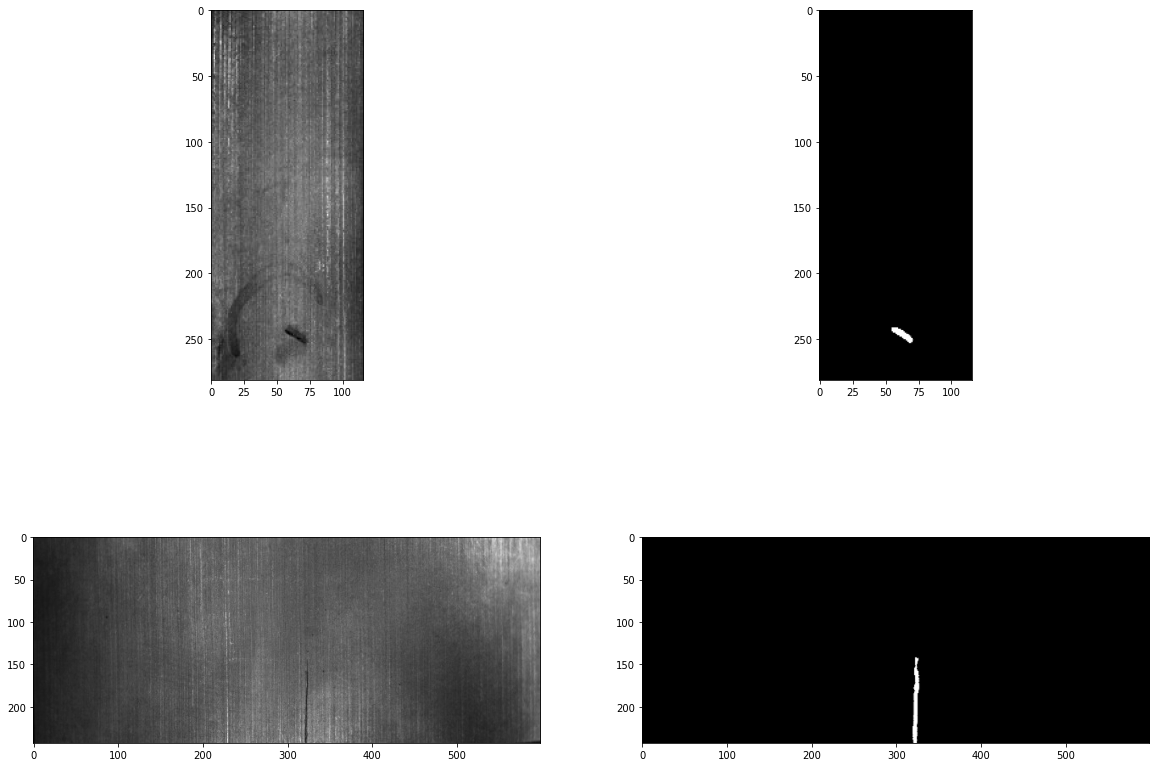

In [13]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944','data/MT_Crack/Imgs/exp1_num_86828']
#Define the size of images
fig =  plt.figure(figsize=(20, 15))
n=len(images_path)
for i, im_path in enumerate(images_path):
    ax = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(Image.open(im_path+'.jpg'), cmap='gray')
    ax = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(Image.open(im_path+'.png'), cmap='gray')

###Visualize transforms on sample images and masks


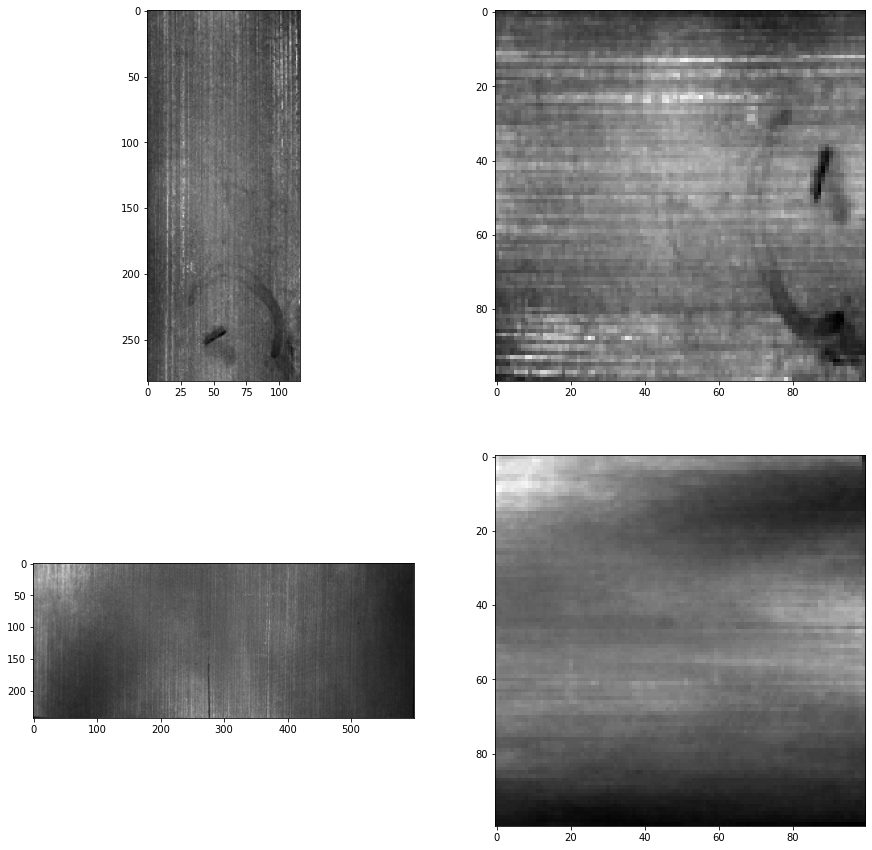

In [14]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944',
            'data/MT_Crack/Imgs/exp1_num_86828']
#Define the size of images
fig =  plt.figure(figsize=(15, 15))
n=len(images_path)
for i, im_path in enumerate(images_path):
    image = Image.open(images_path[i]+'.jpg')
    mask = Image.open(images_path[i]+'.png')
    t1 = HorizontalFlip()
    t2 = Resize((100,100))
    t3 = Rotate(90)
    ax1 = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(t1(image), cmap='gray')  # Added by Ray
    ax2 = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(t3(t2(image)), cmap='gray')


### Some stats about the dataset

In [15]:
#fing the range of height and width of train images
H = []
W = []
pair = []
for p in partition['train']:
  image = Image.open(p)
  W.append(image.size[0])
  H.append(image.size[1])
  pair.append(image.size)
print("maximum height:",max(H),"\tmaximum width:", max(W), "\tminimum height:", min(H), "\tminimum width:", min(W))

maximum height: 403 	maximum width: 618 	minimum height: 222 	minimum width: 105


In [16]:
print('Length of train dataset: ', len(surface_defect_dataset['train']))
print('Length of validation dataset: ', len(surface_defect_dataset['val']))
print('Length of test dataset: ', len(surface_defect_dataset['test']))

Length of train dataset:  175
Length of validation dataset:  24
Length of test dataset:  53


In [17]:
#find the weight of positive and negative pixels
positive_weight = 0
negative_weight = 0
total_pixels = 0
for _, target in surface_defect_dataset['train']:
    positive_weight += ((target.cpu().numpy()) >= threshold).sum()
    negative_weight += ((target.cpu().numpy()) < threshold).sum()
    total_pixels += (224 * 224)
positive_weight /= total_pixels
negative_weight /= total_pixels
print('positive weight = ',positive_weight, '\tnegative weight = ', negative_weight)

positive weight =  0.0019506195335276969 	negative weight =  0.9980493804664723


## Batch and load data

In [18]:
# Generators: load data in batches
loaders={}
loaders['train'] = torch.utils.data.DataLoader(surface_defect_dataset['train'], 
                                               batch_size=batch_size,
                                               shuffle = True,
                                               num_workers=num_workers)
loaders['val'] = torch.utils.data.DataLoader(surface_defect_dataset['val'], 
                                             batch_size=batch_size,
                                             shuffle=False, 
                                             num_workers=num_workers)
loaders['test'] = torch.utils.data.DataLoader(surface_defect_dataset['test'], 
                                              batch_size= test_batch_size, 
                                              shuffle=False, 
                                              num_workers=num_workers)


## Obtain model architecture

In [19]:
# instantiate the unet
model = UNet_2D(1,1,32,0.2).to(device)

In [20]:
# if GPU is available, move the model to GPU
if train_on_gpu:
    model.to(device)

In [21]:
summary(model, (1, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 224, 224]             288
       BatchNorm2d-2         [32, 32, 224, 224]              64
              SiLU-3         [32, 32, 224, 224]               0
            Conv2d-4         [32, 32, 224, 224]           9,216
       BatchNorm2d-5         [32, 32, 224, 224]              64
              SiLU-6         [32, 32, 224, 224]               0
         MaxPool2d-7         [32, 32, 112, 112]               0
           Dropout-8         [32, 32, 112, 112]               0
            Conv2d-9         [32, 64, 112, 112]          18,432
      BatchNorm2d-10         [32, 64, 112, 112]             128
             SiLU-11         [32, 64, 112, 112]               0
           Conv2d-12         [32, 64, 112, 112]          36,864
      BatchNorm2d-13         [32, 64, 112, 112]             128
             SiLU-14         [32, 64, 1

## Specify the loss function and optimizer

In [22]:
if criterion_type == 'WeightedBCE':
    weight = np.array([negative_weight, positive_weight])
    weight = torch.from_numpy(weight)
    criterion = WeightedBCELoss(weights=weight)
else:
    criterion = TverskyLoss(1e-10,0.3,.7)
# Optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
else:
    optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [23]:
"""
If lr_find is True, after running this cell, assign the scheduler's max_lr to 
the suggested maximum lr and then set lr_find to False in the "Set the parameters"
section. Set the lr in the optimizer 1/10 of max_lr. Then re_run the code. 
"""
if lr_find == False:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02,
                                                    steps_per_epoch=len(loaders['train']),
                                                    epochs=n_epochs)     
else:
    #https://github.com/davidtvs/pytorch-lr-finder
    desired_batch_size, real_batch_size = batch_size, batch_size
    accumulation_steps = desired_batch_size // real_batch_size
    lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
    lr_finder.range_test(loaders['train'], end_lr=1, num_iter=100, step_mode='exp')
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state"""

## Train and validate the model

In [24]:
model = train_2D(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, 'model.pt')                

  0%|          | 0/201 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  0%|          | 1/201 [00:06<20:14,  6.07s/it]

Epoch: 1 	Training Loss: 0.9958 	Validation Loss: 0.9975
Validation loss decreased.  Saving model ...
=== Epoch #2 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  1%|          | 2/201 [00:08<16:29,  4.97s/it]

Epoch: 2 	Training Loss: 0.9943 	Validation Loss: 0.9975
Validation loss decreased.  Saving model ...
=== Epoch #3 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  1%|▏         | 3/201 [00:10<13:51,  4.20s/it]

Epoch: 3 	Training Loss: 0.9939 	Validation Loss: 0.9973
Validation loss decreased.  Saving model ...
=== Epoch #4 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  2%|▏         | 4/201 [00:13<11:59,  3.65s/it]

Epoch: 4 	Training Loss: 0.9939 	Validation Loss: 0.9973
Validation loss decreased.  Saving model ...
=== Epoch #5 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  2%|▏         | 5/201 [00:15<10:43,  3.28s/it]

Epoch: 5 	Training Loss: 0.9931 	Validation Loss: 0.9970
Validation loss decreased.  Saving model ...
=== Epoch #6 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  3%|▎         | 6/201 [00:18<09:48,  3.02s/it]

Epoch: 6 	Training Loss: 0.9930 	Validation Loss: 0.9966
Validation loss decreased.  Saving model ...
=== Epoch #7 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  3%|▎         | 7/201 [00:20<09:13,  2.85s/it]

Epoch: 7 	Training Loss: 0.9926 	Validation Loss: 0.9955
Validation loss decreased.  Saving model ...
=== Epoch #8 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  4%|▍         | 8/201 [00:22<08:44,  2.72s/it]

Epoch: 8 	Training Loss: 0.9927 	Validation Loss: 0.9952
Validation loss decreased.  Saving model ...
=== Epoch #9 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  4%|▍         | 9/201 [00:25<08:23,  2.62s/it]

Epoch: 9 	Training Loss: 0.9921 	Validation Loss: 0.9942
Validation loss decreased.  Saving model ...
=== Epoch #10 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  5%|▍         | 10/201 [00:27<08:08,  2.56s/it]

Epoch: 10 	Training Loss: 0.9921 	Validation Loss: 0.9923
Validation loss decreased.  Saving model ...
=== Epoch #11 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  5%|▌         | 11/201 [00:30<07:59,  2.52s/it]

Epoch: 11 	Training Loss: 0.9913 	Validation Loss: 0.9913
Validation loss decreased.  Saving model ...
=== Epoch #12 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  6%|▌         | 12/201 [00:32<07:51,  2.49s/it]

Epoch: 12 	Training Loss: 0.9910 	Validation Loss: 0.9910
Validation loss decreased.  Saving model ...
=== Epoch #13 ===
=== Training ===
1 / 6...
=== Validation ===


  6%|▋         | 13/201 [00:35<07:44,  2.47s/it]

1 / 1...
Epoch: 13 	Training Loss: 0.9912 	Validation Loss: 0.9895
Validation loss decreased.  Saving model ...
=== Epoch #14 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  7%|▋         | 14/201 [00:37<07:34,  2.43s/it]

Epoch: 14 	Training Loss: 0.9904 	Validation Loss: 0.9900
=== Epoch #15 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  7%|▋         | 15/201 [00:39<07:25,  2.39s/it]

Epoch: 15 	Training Loss: 0.9900 	Validation Loss: 0.9897
=== Epoch #16 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  8%|▊         | 16/201 [00:41<07:17,  2.37s/it]

Epoch: 16 	Training Loss: 0.9891 	Validation Loss: 0.9911
=== Epoch #17 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  8%|▊         | 17/201 [00:44<07:12,  2.35s/it]

Epoch: 17 	Training Loss: 0.9890 	Validation Loss: 0.9899
=== Epoch #18 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  9%|▉         | 18/201 [00:46<07:13,  2.37s/it]

Epoch: 18 	Training Loss: 0.9885 	Validation Loss: 0.9894
Validation loss decreased.  Saving model ...
=== Epoch #19 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  9%|▉         | 19/201 [00:49<07:13,  2.38s/it]

Epoch: 19 	Training Loss: 0.9874 	Validation Loss: 0.9887
Validation loss decreased.  Saving model ...
=== Epoch #20 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 10%|▉         | 20/201 [00:51<07:12,  2.39s/it]

Epoch: 20 	Training Loss: 0.9866 	Validation Loss: 0.9878
Validation loss decreased.  Saving model ...
=== Epoch #21 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 10%|█         | 21/201 [00:53<07:11,  2.40s/it]

Epoch: 21 	Training Loss: 0.9858 	Validation Loss: 0.9859
Validation loss decreased.  Saving model ...
=== Epoch #22 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 11%|█         | 22/201 [00:56<07:04,  2.37s/it]

Epoch: 22 	Training Loss: 0.9837 	Validation Loss: 0.9862
=== Epoch #23 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 11%|█▏        | 23/201 [00:58<07:04,  2.38s/it]

Epoch: 23 	Training Loss: 0.9835 	Validation Loss: 0.9845
Validation loss decreased.  Saving model ...
=== Epoch #24 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 12%|█▏        | 24/201 [01:00<06:59,  2.37s/it]

Epoch: 24 	Training Loss: 0.9810 	Validation Loss: 0.9853
=== Epoch #25 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 12%|█▏        | 25/201 [01:03<06:58,  2.38s/it]

Epoch: 25 	Training Loss: 0.9801 	Validation Loss: 0.9844
Validation loss decreased.  Saving model ...
=== Epoch #26 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 13%|█▎        | 26/201 [01:05<06:59,  2.39s/it]

Epoch: 26 	Training Loss: 0.9794 	Validation Loss: 0.9776
Validation loss decreased.  Saving model ...
=== Epoch #27 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 13%|█▎        | 27/201 [01:08<06:53,  2.37s/it]

Epoch: 27 	Training Loss: 0.9764 	Validation Loss: 0.9804
=== Epoch #28 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 14%|█▍        | 28/201 [01:10<06:47,  2.36s/it]

Epoch: 28 	Training Loss: 0.9743 	Validation Loss: 0.9836
=== Epoch #29 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 14%|█▍        | 29/201 [01:12<06:43,  2.34s/it]

Epoch: 29 	Training Loss: 0.9702 	Validation Loss: 0.9795
=== Epoch #30 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 15%|█▍        | 30/201 [01:15<06:44,  2.37s/it]

Epoch: 30 	Training Loss: 0.9657 	Validation Loss: 0.9736
Validation loss decreased.  Saving model ...
=== Epoch #31 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 15%|█▌        | 31/201 [01:17<06:44,  2.38s/it]

Epoch: 31 	Training Loss: 0.9634 	Validation Loss: 0.9725
Validation loss decreased.  Saving model ...
=== Epoch #32 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 16%|█▌        | 32/201 [01:20<06:44,  2.39s/it]

Epoch: 32 	Training Loss: 0.9582 	Validation Loss: 0.9627
Validation loss decreased.  Saving model ...
=== Epoch #33 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 16%|█▋        | 33/201 [01:22<06:43,  2.40s/it]

Epoch: 33 	Training Loss: 0.9512 	Validation Loss: 0.9580
Validation loss decreased.  Saving model ...
=== Epoch #34 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 17%|█▋        | 34/201 [01:24<06:41,  2.41s/it]

Epoch: 34 	Training Loss: 0.9436 	Validation Loss: 0.9446
Validation loss decreased.  Saving model ...
=== Epoch #35 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 17%|█▋        | 35/201 [01:27<06:39,  2.41s/it]

Epoch: 35 	Training Loss: 0.9335 	Validation Loss: 0.9432
Validation loss decreased.  Saving model ...
=== Epoch #36 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 18%|█▊        | 36/201 [01:29<06:40,  2.43s/it]

Epoch: 36 	Training Loss: 0.9272 	Validation Loss: 0.9301
Validation loss decreased.  Saving model ...
=== Epoch #37 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 18%|█▊        | 37/201 [01:32<06:38,  2.43s/it]

Epoch: 37 	Training Loss: 0.9143 	Validation Loss: 0.9190
Validation loss decreased.  Saving model ...
=== Epoch #38 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 19%|█▉        | 38/201 [01:34<06:35,  2.43s/it]

Epoch: 38 	Training Loss: 0.8978 	Validation Loss: 0.8906
Validation loss decreased.  Saving model ...
=== Epoch #39 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 19%|█▉        | 39/201 [01:36<06:28,  2.40s/it]

Epoch: 39 	Training Loss: 0.8760 	Validation Loss: 0.8986
=== Epoch #40 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 20%|█▉        | 40/201 [01:39<06:22,  2.38s/it]

Epoch: 40 	Training Loss: 0.8604 	Validation Loss: 0.9348
=== Epoch #41 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 20%|██        | 41/201 [01:41<06:21,  2.38s/it]

Epoch: 41 	Training Loss: 0.8326 	Validation Loss: 0.8858
Validation loss decreased.  Saving model ...
=== Epoch #42 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 21%|██        | 42/201 [01:44<06:19,  2.39s/it]

Epoch: 42 	Training Loss: 0.7949 	Validation Loss: 0.8223
Validation loss decreased.  Saving model ...
=== Epoch #43 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 21%|██▏       | 43/201 [01:46<06:16,  2.39s/it]

Epoch: 43 	Training Loss: 0.7626 	Validation Loss: 0.7583
Validation loss decreased.  Saving model ...
=== Epoch #44 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 22%|██▏       | 44/201 [01:48<06:15,  2.39s/it]

Epoch: 44 	Training Loss: 0.7188 	Validation Loss: 0.7562
Validation loss decreased.  Saving model ...
=== Epoch #45 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 22%|██▏       | 45/201 [01:51<06:11,  2.38s/it]

Epoch: 45 	Training Loss: 0.6923 	Validation Loss: 0.7994
=== Epoch #46 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 23%|██▎       | 46/201 [01:53<06:10,  2.39s/it]

Epoch: 46 	Training Loss: 0.6694 	Validation Loss: 0.7294
Validation loss decreased.  Saving model ...
=== Epoch #47 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 23%|██▎       | 47/201 [01:56<06:09,  2.40s/it]

Epoch: 47 	Training Loss: 0.6385 	Validation Loss: 0.6621
Validation loss decreased.  Saving model ...
=== Epoch #48 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 24%|██▍       | 48/201 [01:58<06:06,  2.39s/it]

Epoch: 48 	Training Loss: 0.5857 	Validation Loss: 0.6484
Validation loss decreased.  Saving model ...
=== Epoch #49 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 24%|██▍       | 49/201 [02:00<06:04,  2.40s/it]

Epoch: 49 	Training Loss: 0.5311 	Validation Loss: 0.5929
Validation loss decreased.  Saving model ...
=== Epoch #50 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 25%|██▍       | 50/201 [02:03<05:58,  2.38s/it]

Epoch: 50 	Training Loss: 0.4943 	Validation Loss: 0.6124
=== Epoch #51 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 25%|██▌       | 51/201 [02:05<05:58,  2.39s/it]

Epoch: 51 	Training Loss: 0.4691 	Validation Loss: 0.5884
Validation loss decreased.  Saving model ...
=== Epoch #52 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 26%|██▌       | 52/201 [02:07<05:56,  2.39s/it]

Epoch: 52 	Training Loss: 0.3947 	Validation Loss: 0.4657
Validation loss decreased.  Saving model ...
=== Epoch #53 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 26%|██▋       | 53/201 [02:10<05:50,  2.37s/it]

Epoch: 53 	Training Loss: 0.4154 	Validation Loss: 0.5061
=== Epoch #54 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 27%|██▋       | 54/201 [02:12<05:46,  2.35s/it]

Epoch: 54 	Training Loss: 0.3681 	Validation Loss: 0.4938
=== Epoch #55 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 27%|██▋       | 55/201 [02:15<05:46,  2.37s/it]

Epoch: 55 	Training Loss: 0.3700 	Validation Loss: 0.3920
Validation loss decreased.  Saving model ...
=== Epoch #56 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 28%|██▊       | 56/201 [02:17<05:41,  2.35s/it]

Epoch: 56 	Training Loss: 0.3382 	Validation Loss: 0.4491
=== Epoch #57 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 28%|██▊       | 57/201 [02:19<05:36,  2.34s/it]

Epoch: 57 	Training Loss: 0.3163 	Validation Loss: 0.5031
=== Epoch #58 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 29%|██▉       | 58/201 [02:21<05:32,  2.32s/it]

Epoch: 58 	Training Loss: 0.3148 	Validation Loss: 0.4954
=== Epoch #59 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 29%|██▉       | 59/201 [02:24<05:28,  2.32s/it]

Epoch: 59 	Training Loss: 0.3298 	Validation Loss: 0.4450
=== Epoch #60 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 30%|██▉       | 60/201 [02:26<05:26,  2.31s/it]

Epoch: 60 	Training Loss: 0.2876 	Validation Loss: 0.3944
=== Epoch #61 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 30%|███       | 61/201 [02:28<05:27,  2.34s/it]

Epoch: 61 	Training Loss: 0.2770 	Validation Loss: 0.3471
Validation loss decreased.  Saving model ...
=== Epoch #62 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 31%|███       | 62/201 [02:31<05:25,  2.34s/it]

Epoch: 62 	Training Loss: 0.3016 	Validation Loss: 0.3648
=== Epoch #63 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 31%|███▏      | 63/201 [02:33<05:21,  2.33s/it]

Epoch: 63 	Training Loss: 0.2802 	Validation Loss: 0.3656
=== Epoch #64 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 32%|███▏      | 64/201 [02:35<05:21,  2.35s/it]

Epoch: 64 	Training Loss: 0.2863 	Validation Loss: 0.2815
Validation loss decreased.  Saving model ...
=== Epoch #65 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 32%|███▏      | 65/201 [02:38<05:22,  2.37s/it]

Epoch: 65 	Training Loss: 0.2570 	Validation Loss: 0.2754
Validation loss decreased.  Saving model ...
=== Epoch #66 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 33%|███▎      | 66/201 [02:40<05:18,  2.36s/it]

Epoch: 66 	Training Loss: 0.2606 	Validation Loss: 0.2967
=== Epoch #67 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 33%|███▎      | 67/201 [02:43<05:14,  2.35s/it]

Epoch: 67 	Training Loss: 0.2445 	Validation Loss: 0.3208
=== Epoch #68 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 34%|███▍      | 68/201 [02:45<05:10,  2.34s/it]

Epoch: 68 	Training Loss: 0.2565 	Validation Loss: 0.3201
=== Epoch #69 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 34%|███▍      | 69/201 [02:47<05:07,  2.33s/it]

Epoch: 69 	Training Loss: 0.2472 	Validation Loss: 0.3193
=== Epoch #70 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 35%|███▍      | 70/201 [02:49<05:04,  2.33s/it]

Epoch: 70 	Training Loss: 0.2435 	Validation Loss: 0.3035
=== Epoch #71 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 35%|███▌      | 71/201 [02:52<05:01,  2.32s/it]

Epoch: 71 	Training Loss: 0.2695 	Validation Loss: 0.3128
=== Epoch #72 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 36%|███▌      | 72/201 [02:54<04:59,  2.32s/it]

Epoch: 72 	Training Loss: 0.2698 	Validation Loss: 0.3323
=== Epoch #73 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 36%|███▋      | 73/201 [02:56<04:55,  2.31s/it]

Epoch: 73 	Training Loss: 0.2839 	Validation Loss: 0.3144
=== Epoch #74 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 37%|███▋      | 74/201 [02:59<04:53,  2.31s/it]

Epoch: 74 	Training Loss: 0.2322 	Validation Loss: 0.3335
=== Epoch #75 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 37%|███▋      | 75/201 [03:01<04:50,  2.31s/it]

Epoch: 75 	Training Loss: 0.2495 	Validation Loss: 0.3358
=== Epoch #76 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 38%|███▊      | 76/201 [03:03<04:48,  2.31s/it]

Epoch: 76 	Training Loss: 0.2644 	Validation Loss: 0.3277
=== Epoch #77 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 38%|███▊      | 77/201 [03:06<04:46,  2.31s/it]

Epoch: 77 	Training Loss: 0.2395 	Validation Loss: 0.3238
=== Epoch #78 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 39%|███▉      | 78/201 [03:08<04:44,  2.31s/it]

Epoch: 78 	Training Loss: 0.2714 	Validation Loss: 0.3247
=== Epoch #79 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 39%|███▉      | 79/201 [03:10<04:41,  2.31s/it]

Epoch: 79 	Training Loss: 0.2467 	Validation Loss: 0.3200
=== Epoch #80 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 40%|███▉      | 80/201 [03:13<04:38,  2.31s/it]

Epoch: 80 	Training Loss: 0.2455 	Validation Loss: 0.3438
=== Epoch #81 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 40%|████      | 81/201 [03:15<04:36,  2.31s/it]

Epoch: 81 	Training Loss: 0.2495 	Validation Loss: 0.3521
=== Epoch #82 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 41%|████      | 82/201 [03:17<04:34,  2.31s/it]

Epoch: 82 	Training Loss: 0.2427 	Validation Loss: 0.3175
=== Epoch #83 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 41%|████▏     | 83/201 [03:19<04:31,  2.30s/it]

Epoch: 83 	Training Loss: 0.2286 	Validation Loss: 0.3218
=== Epoch #84 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 42%|████▏     | 84/201 [03:22<04:28,  2.30s/it]

Epoch: 84 	Training Loss: 0.2287 	Validation Loss: 0.3289
=== Epoch #85 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 42%|████▏     | 85/201 [03:24<04:27,  2.30s/it]

Epoch: 85 	Training Loss: 0.2246 	Validation Loss: 0.3532
=== Epoch #86 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 43%|████▎     | 86/201 [03:26<04:24,  2.30s/it]

Epoch: 86 	Training Loss: 0.2430 	Validation Loss: 0.3669
=== Epoch #87 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 43%|████▎     | 87/201 [03:29<04:22,  2.30s/it]

Epoch: 87 	Training Loss: 0.2323 	Validation Loss: 0.3461
=== Epoch #88 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 44%|████▍     | 88/201 [03:31<04:20,  2.30s/it]

Epoch: 88 	Training Loss: 0.2432 	Validation Loss: 0.3149
=== Epoch #89 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 44%|████▍     | 89/201 [03:33<04:18,  2.31s/it]

Epoch: 89 	Training Loss: 0.2220 	Validation Loss: 0.3073
=== Epoch #90 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 45%|████▍     | 90/201 [03:36<04:16,  2.31s/it]

Epoch: 90 	Training Loss: 0.2179 	Validation Loss: 0.2942
=== Epoch #91 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 45%|████▌     | 91/201 [03:38<04:13,  2.31s/it]

Epoch: 91 	Training Loss: 0.2239 	Validation Loss: 0.3151
=== Epoch #92 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 46%|████▌     | 92/201 [03:40<04:11,  2.31s/it]

Epoch: 92 	Training Loss: 0.2129 	Validation Loss: 0.2966
=== Epoch #93 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 46%|████▋     | 93/201 [03:43<04:08,  2.30s/it]

Epoch: 93 	Training Loss: 0.2002 	Validation Loss: 0.3139
=== Epoch #94 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 47%|████▋     | 94/201 [03:45<04:05,  2.30s/it]

Epoch: 94 	Training Loss: 0.2093 	Validation Loss: 0.3251
=== Epoch #95 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 47%|████▋     | 95/201 [03:47<04:03,  2.30s/it]

Epoch: 95 	Training Loss: 0.2001 	Validation Loss: 0.3560
=== Epoch #96 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 48%|████▊     | 96/201 [03:49<04:01,  2.30s/it]

Epoch: 96 	Training Loss: 0.2362 	Validation Loss: 0.3681
=== Epoch #97 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 48%|████▊     | 97/201 [03:52<04:00,  2.31s/it]

Epoch: 97 	Training Loss: 0.2418 	Validation Loss: 0.3711
=== Epoch #98 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 49%|████▉     | 98/201 [03:54<03:57,  2.31s/it]

Epoch: 98 	Training Loss: 0.2232 	Validation Loss: 0.3600
=== Epoch #99 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 49%|████▉     | 99/201 [03:56<03:54,  2.30s/it]

Epoch: 99 	Training Loss: 0.2179 	Validation Loss: 0.3256
=== Epoch #100 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 50%|████▉     | 100/201 [03:59<03:52,  2.30s/it]

Epoch: 100 	Training Loss: 0.2128 	Validation Loss: 0.3142
=== Epoch #101 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 50%|█████     | 101/201 [04:01<03:50,  2.30s/it]

Epoch: 101 	Training Loss: 0.1990 	Validation Loss: 0.3274
=== Epoch #102 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 51%|█████     | 102/201 [04:03<03:48,  2.30s/it]

Epoch: 102 	Training Loss: 0.2309 	Validation Loss: 0.3007
=== Epoch #103 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 51%|█████     | 103/201 [04:06<03:46,  2.31s/it]

Epoch: 103 	Training Loss: 0.2348 	Validation Loss: 0.2852
=== Epoch #104 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 52%|█████▏    | 104/201 [04:08<03:43,  2.30s/it]

Epoch: 104 	Training Loss: 0.2032 	Validation Loss: 0.2760
=== Epoch #105 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 52%|█████▏    | 105/201 [04:10<03:41,  2.31s/it]

Epoch: 105 	Training Loss: 0.2119 	Validation Loss: 0.2866
=== Epoch #106 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 53%|█████▎    | 106/201 [04:12<03:38,  2.30s/it]

Epoch: 106 	Training Loss: 0.2025 	Validation Loss: 0.3129
=== Epoch #107 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 53%|█████▎    | 107/201 [04:15<03:35,  2.30s/it]

Epoch: 107 	Training Loss: 0.1942 	Validation Loss: 0.3391
=== Epoch #108 ===
=== Training ===
1 / 6...
=== Validation ===


 54%|█████▎    | 108/201 [04:17<03:33,  2.30s/it]

1 / 1...
Epoch: 108 	Training Loss: 0.2075 	Validation Loss: 0.3359
=== Epoch #109 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 54%|█████▍    | 109/201 [04:19<03:31,  2.30s/it]

Epoch: 109 	Training Loss: 0.1933 	Validation Loss: 0.3187
=== Epoch #110 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 55%|█████▍    | 110/201 [04:22<03:29,  2.30s/it]

Epoch: 110 	Training Loss: 0.2041 	Validation Loss: 0.2855
=== Epoch #111 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 55%|█████▌    | 111/201 [04:24<03:27,  2.30s/it]

Epoch: 111 	Training Loss: 0.2151 	Validation Loss: 0.2899
=== Epoch #112 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 56%|█████▌    | 112/201 [04:26<03:25,  2.31s/it]

Epoch: 112 	Training Loss: 0.2084 	Validation Loss: 0.2796
=== Epoch #113 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 56%|█████▌    | 113/201 [04:29<03:23,  2.31s/it]

Epoch: 113 	Training Loss: 0.1973 	Validation Loss: 0.2775
=== Epoch #114 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 57%|█████▋    | 114/201 [04:31<03:21,  2.31s/it]

Epoch: 114 	Training Loss: 0.1895 	Validation Loss: 0.3095
=== Epoch #115 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 57%|█████▋    | 115/201 [04:33<03:21,  2.34s/it]

Epoch: 115 	Training Loss: 0.2015 	Validation Loss: 0.2677
Validation loss decreased.  Saving model ...
=== Epoch #116 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 58%|█████▊    | 116/201 [04:36<03:19,  2.35s/it]

Epoch: 116 	Training Loss: 0.1985 	Validation Loss: 0.2602
Validation loss decreased.  Saving model ...
=== Epoch #117 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 58%|█████▊    | 117/201 [04:38<03:18,  2.36s/it]

Epoch: 117 	Training Loss: 0.1889 	Validation Loss: 0.2575
Validation loss decreased.  Saving model ...
=== Epoch #118 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 59%|█████▊    | 118/201 [04:41<03:17,  2.38s/it]

Epoch: 118 	Training Loss: 0.1924 	Validation Loss: 0.2244
Validation loss decreased.  Saving model ...
=== Epoch #119 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 59%|█████▉    | 119/201 [04:43<03:13,  2.35s/it]

Epoch: 119 	Training Loss: 0.1954 	Validation Loss: 0.2393
=== Epoch #120 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 60%|█████▉    | 120/201 [04:45<03:09,  2.34s/it]

Epoch: 120 	Training Loss: 0.1821 	Validation Loss: 0.2458
=== Epoch #121 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 60%|██████    | 121/201 [04:47<03:06,  2.33s/it]

Epoch: 121 	Training Loss: 0.2230 	Validation Loss: 0.2953
=== Epoch #122 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 61%|██████    | 122/201 [04:50<03:03,  2.32s/it]

Epoch: 122 	Training Loss: 0.1937 	Validation Loss: 0.2540
=== Epoch #123 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 61%|██████    | 123/201 [04:52<03:01,  2.32s/it]

Epoch: 123 	Training Loss: 0.2009 	Validation Loss: 0.3489
=== Epoch #124 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 62%|██████▏   | 124/201 [04:54<02:58,  2.31s/it]

Epoch: 124 	Training Loss: 0.2239 	Validation Loss: 0.3895
=== Epoch #125 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 62%|██████▏   | 125/201 [04:57<02:56,  2.33s/it]

Epoch: 125 	Training Loss: 0.2233 	Validation Loss: 0.3527
=== Epoch #126 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 63%|██████▎   | 126/201 [04:59<02:54,  2.32s/it]

Epoch: 126 	Training Loss: 0.2039 	Validation Loss: 0.3128
=== Epoch #127 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 63%|██████▎   | 127/201 [05:01<02:51,  2.32s/it]

Epoch: 127 	Training Loss: 0.2006 	Validation Loss: 0.3119
=== Epoch #128 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 64%|██████▎   | 128/201 [05:04<02:48,  2.31s/it]

Epoch: 128 	Training Loss: 0.1940 	Validation Loss: 0.3053
=== Epoch #129 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 64%|██████▍   | 129/201 [05:06<02:46,  2.31s/it]

Epoch: 129 	Training Loss: 0.1815 	Validation Loss: 0.3047
=== Epoch #130 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 65%|██████▍   | 130/201 [05:08<02:43,  2.31s/it]

Epoch: 130 	Training Loss: 0.1937 	Validation Loss: 0.2926
=== Epoch #131 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 65%|██████▌   | 131/201 [05:11<02:41,  2.31s/it]

Epoch: 131 	Training Loss: 0.1772 	Validation Loss: 0.2797
=== Epoch #132 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 66%|██████▌   | 132/201 [05:13<02:38,  2.30s/it]

Epoch: 132 	Training Loss: 0.1843 	Validation Loss: 0.2644
=== Epoch #133 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 66%|██████▌   | 133/201 [05:15<02:36,  2.31s/it]

Epoch: 133 	Training Loss: 0.1816 	Validation Loss: 0.2747
=== Epoch #134 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 67%|██████▋   | 134/201 [05:17<02:34,  2.30s/it]

Epoch: 134 	Training Loss: 0.1848 	Validation Loss: 0.2829
=== Epoch #135 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 67%|██████▋   | 135/201 [05:20<02:32,  2.31s/it]

Epoch: 135 	Training Loss: 0.1746 	Validation Loss: 0.2750
=== Epoch #136 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 68%|██████▊   | 136/201 [05:22<02:30,  2.32s/it]

Epoch: 136 	Training Loss: 0.1808 	Validation Loss: 0.2494
=== Epoch #137 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 68%|██████▊   | 137/201 [05:24<02:27,  2.31s/it]

Epoch: 137 	Training Loss: 0.1695 	Validation Loss: 0.2291
=== Epoch #138 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 69%|██████▊   | 138/201 [05:27<02:25,  2.30s/it]

Epoch: 138 	Training Loss: 0.1746 	Validation Loss: 0.2501
=== Epoch #139 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 69%|██████▉   | 139/201 [05:29<02:24,  2.33s/it]

Epoch: 139 	Training Loss: 0.1751 	Validation Loss: 0.2222
Validation loss decreased.  Saving model ...
=== Epoch #140 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 70%|██████▉   | 140/201 [05:31<02:23,  2.35s/it]

Epoch: 140 	Training Loss: 0.1723 	Validation Loss: 0.2065
Validation loss decreased.  Saving model ...
=== Epoch #141 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 70%|███████   | 141/201 [05:34<02:21,  2.37s/it]

Epoch: 141 	Training Loss: 0.1672 	Validation Loss: 0.2012
Validation loss decreased.  Saving model ...
=== Epoch #142 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 71%|███████   | 142/201 [05:36<02:18,  2.35s/it]

Epoch: 142 	Training Loss: 0.1729 	Validation Loss: 0.2289
=== Epoch #143 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 71%|███████   | 143/201 [05:39<02:15,  2.34s/it]

Epoch: 143 	Training Loss: 0.1751 	Validation Loss: 0.2482
=== Epoch #144 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 72%|███████▏  | 144/201 [05:41<02:12,  2.33s/it]

Epoch: 144 	Training Loss: 0.1697 	Validation Loss: 0.2104
=== Epoch #145 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 72%|███████▏  | 145/201 [05:43<02:11,  2.34s/it]

Epoch: 145 	Training Loss: 0.1687 	Validation Loss: 0.2239
=== Epoch #146 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 73%|███████▎  | 146/201 [05:45<02:08,  2.33s/it]

Epoch: 146 	Training Loss: 0.1726 	Validation Loss: 0.2152
=== Epoch #147 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 73%|███████▎  | 147/201 [05:48<02:05,  2.33s/it]

Epoch: 147 	Training Loss: 0.1786 	Validation Loss: 0.2180
=== Epoch #148 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 74%|███████▎  | 148/201 [05:50<02:03,  2.32s/it]

Epoch: 148 	Training Loss: 0.1719 	Validation Loss: 0.2638
=== Epoch #149 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 74%|███████▍  | 149/201 [05:52<02:00,  2.32s/it]

Epoch: 149 	Training Loss: 0.1750 	Validation Loss: 0.2832
=== Epoch #150 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 75%|███████▍  | 150/201 [05:55<01:58,  2.32s/it]

Epoch: 150 	Training Loss: 0.1756 	Validation Loss: 0.2413
=== Epoch #151 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 75%|███████▌  | 151/201 [05:57<01:55,  2.31s/it]

Epoch: 151 	Training Loss: 0.1788 	Validation Loss: 0.2268
=== Epoch #152 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 76%|███████▌  | 152/201 [05:59<01:53,  2.31s/it]

Epoch: 152 	Training Loss: 0.1846 	Validation Loss: 0.2489
=== Epoch #153 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 76%|███████▌  | 153/201 [06:02<01:50,  2.31s/it]

Epoch: 153 	Training Loss: 0.1753 	Validation Loss: 0.2616
=== Epoch #154 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 77%|███████▋  | 154/201 [06:04<01:48,  2.31s/it]

Epoch: 154 	Training Loss: 0.1851 	Validation Loss: 0.2886
=== Epoch #155 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 77%|███████▋  | 155/201 [06:06<01:46,  2.31s/it]

Epoch: 155 	Training Loss: 0.1743 	Validation Loss: 0.3061
=== Epoch #156 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 78%|███████▊  | 156/201 [06:09<01:43,  2.30s/it]

Epoch: 156 	Training Loss: 0.1921 	Validation Loss: 0.2680
=== Epoch #157 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 78%|███████▊  | 157/201 [06:11<01:41,  2.30s/it]

Epoch: 157 	Training Loss: 0.2007 	Validation Loss: 0.2352
=== Epoch #158 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 79%|███████▊  | 158/201 [06:13<01:39,  2.30s/it]

Epoch: 158 	Training Loss: 0.1943 	Validation Loss: 0.2231
=== Epoch #159 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 79%|███████▉  | 159/201 [06:15<01:36,  2.30s/it]

Epoch: 159 	Training Loss: 0.1854 	Validation Loss: 0.2496
=== Epoch #160 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 80%|███████▉  | 160/201 [06:18<01:34,  2.30s/it]

Epoch: 160 	Training Loss: 0.1757 	Validation Loss: 0.2646
=== Epoch #161 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 80%|████████  | 161/201 [06:20<01:32,  2.30s/it]

Epoch: 161 	Training Loss: 0.1910 	Validation Loss: 0.2848
=== Epoch #162 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 81%|████████  | 162/201 [06:22<01:29,  2.30s/it]

Epoch: 162 	Training Loss: 0.1736 	Validation Loss: 0.2523
=== Epoch #163 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 81%|████████  | 163/201 [06:25<01:27,  2.30s/it]

Epoch: 163 	Training Loss: 0.1736 	Validation Loss: 0.2333
=== Epoch #164 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 82%|████████▏ | 164/201 [06:27<01:25,  2.30s/it]

Epoch: 164 	Training Loss: 0.1906 	Validation Loss: 0.2534
=== Epoch #165 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 82%|████████▏ | 165/201 [06:29<01:22,  2.30s/it]

Epoch: 165 	Training Loss: 0.1636 	Validation Loss: 0.2869
=== Epoch #166 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 83%|████████▎ | 166/201 [06:32<01:20,  2.30s/it]

Epoch: 166 	Training Loss: 0.1671 	Validation Loss: 0.3192
=== Epoch #167 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 83%|████████▎ | 167/201 [06:34<01:17,  2.29s/it]

Epoch: 167 	Training Loss: 0.1815 	Validation Loss: 0.3113
=== Epoch #168 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 84%|████████▎ | 168/201 [06:36<01:15,  2.30s/it]

Epoch: 168 	Training Loss: 0.1744 	Validation Loss: 0.2778
=== Epoch #169 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 84%|████████▍ | 169/201 [06:38<01:13,  2.29s/it]

Epoch: 169 	Training Loss: 0.1822 	Validation Loss: 0.2589
=== Epoch #170 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 85%|████████▍ | 170/201 [06:41<01:11,  2.29s/it]

Epoch: 170 	Training Loss: 0.1673 	Validation Loss: 0.2414
=== Epoch #171 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 85%|████████▌ | 171/201 [06:43<01:09,  2.30s/it]

Epoch: 171 	Training Loss: 0.1701 	Validation Loss: 0.2967
=== Epoch #172 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 86%|████████▌ | 172/201 [06:45<01:06,  2.30s/it]

Epoch: 172 	Training Loss: 0.1882 	Validation Loss: 0.3027
=== Epoch #173 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 86%|████████▌ | 173/201 [06:48<01:04,  2.30s/it]

Epoch: 173 	Training Loss: 0.1761 	Validation Loss: 0.2883
=== Epoch #174 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 87%|████████▋ | 174/201 [06:50<01:02,  2.30s/it]

Epoch: 174 	Training Loss: 0.1735 	Validation Loss: 0.2691
=== Epoch #175 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 87%|████████▋ | 175/201 [06:52<00:59,  2.29s/it]

Epoch: 175 	Training Loss: 0.1760 	Validation Loss: 0.2732
=== Epoch #176 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 88%|████████▊ | 176/201 [06:55<00:57,  2.30s/it]

Epoch: 176 	Training Loss: 0.1876 	Validation Loss: 0.2739
=== Epoch #177 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 88%|████████▊ | 177/201 [06:57<00:55,  2.30s/it]

Epoch: 177 	Training Loss: 0.1790 	Validation Loss: 0.2367
=== Epoch #178 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 89%|████████▊ | 178/201 [06:59<00:52,  2.29s/it]

Epoch: 178 	Training Loss: 0.1783 	Validation Loss: 0.2320
=== Epoch #179 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 89%|████████▉ | 179/201 [07:01<00:50,  2.30s/it]

Epoch: 179 	Training Loss: 0.1808 	Validation Loss: 0.2379
=== Epoch #180 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 90%|████████▉ | 180/201 [07:04<00:48,  2.29s/it]

Epoch: 180 	Training Loss: 0.1769 	Validation Loss: 0.2415
=== Epoch #181 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 90%|█████████ | 181/201 [07:06<00:45,  2.30s/it]

Epoch: 181 	Training Loss: 0.1700 	Validation Loss: 0.2197
=== Epoch #182 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 91%|█████████ | 182/201 [07:08<00:44,  2.33s/it]

Epoch: 182 	Training Loss: 0.1616 	Validation Loss: 0.1949
Validation loss decreased.  Saving model ...
=== Epoch #183 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 91%|█████████ | 183/201 [07:11<00:41,  2.32s/it]

Epoch: 183 	Training Loss: 0.1727 	Validation Loss: 0.2204
=== Epoch #184 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 92%|█████████▏| 184/201 [07:13<00:39,  2.32s/it]

Epoch: 184 	Training Loss: 0.1714 	Validation Loss: 0.2938
=== Epoch #185 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 92%|█████████▏| 185/201 [07:15<00:37,  2.32s/it]

Epoch: 185 	Training Loss: 0.1751 	Validation Loss: 0.3023
=== Epoch #186 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 93%|█████████▎| 186/201 [07:18<00:34,  2.31s/it]

Epoch: 186 	Training Loss: 0.1682 	Validation Loss: 0.2697
=== Epoch #187 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 93%|█████████▎| 187/201 [07:20<00:32,  2.31s/it]

Epoch: 187 	Training Loss: 0.1829 	Validation Loss: 0.2317
=== Epoch #188 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 94%|█████████▎| 188/201 [07:22<00:30,  2.33s/it]

Epoch: 188 	Training Loss: 0.1628 	Validation Loss: 0.1861
Validation loss decreased.  Saving model ...
=== Epoch #189 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 94%|█████████▍| 189/201 [07:25<00:27,  2.33s/it]

Epoch: 189 	Training Loss: 0.1750 	Validation Loss: 0.1971
=== Epoch #190 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 95%|█████████▍| 190/201 [07:27<00:25,  2.33s/it]

Epoch: 190 	Training Loss: 0.1664 	Validation Loss: 0.2231
=== Epoch #191 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 95%|█████████▌| 191/201 [07:29<00:23,  2.33s/it]

Epoch: 191 	Training Loss: 0.1631 	Validation Loss: 0.1948
=== Epoch #192 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 96%|█████████▌| 192/201 [07:32<00:20,  2.33s/it]

Epoch: 192 	Training Loss: 0.1532 	Validation Loss: 0.1863
=== Epoch #193 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 96%|█████████▌| 193/201 [07:34<00:18,  2.32s/it]

Epoch: 193 	Training Loss: 0.1686 	Validation Loss: 0.2234
=== Epoch #194 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 97%|█████████▋| 194/201 [07:36<00:16,  2.31s/it]

Epoch: 194 	Training Loss: 0.1630 	Validation Loss: 0.2508
=== Epoch #195 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 97%|█████████▋| 195/201 [07:39<00:13,  2.31s/it]

Epoch: 195 	Training Loss: 0.1599 	Validation Loss: 0.2403
=== Epoch #196 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 98%|█████████▊| 196/201 [07:41<00:11,  2.31s/it]

Epoch: 196 	Training Loss: 0.1627 	Validation Loss: 0.2091
=== Epoch #197 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 98%|█████████▊| 197/201 [07:43<00:09,  2.31s/it]

Epoch: 197 	Training Loss: 0.1669 	Validation Loss: 0.2080
=== Epoch #198 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 99%|█████████▊| 198/201 [07:45<00:06,  2.30s/it]

Epoch: 198 	Training Loss: 0.1705 	Validation Loss: 0.2634
=== Epoch #199 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 99%|█████████▉| 199/201 [07:48<00:04,  2.30s/it]

Epoch: 199 	Training Loss: 0.1654 	Validation Loss: 0.2571
=== Epoch #200 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


100%|█████████▉| 200/201 [07:50<00:02,  2.35s/it]

Epoch: 200 	Training Loss: 0.1648 	Validation Loss: 0.2116


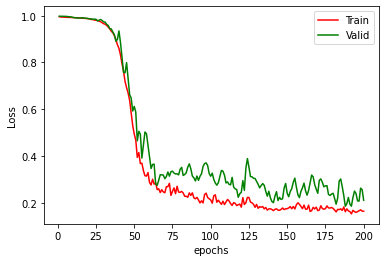

In [25]:
# plot the variation of train and validation losses vs n_epochs
loss=pd.read_csv('loss_epoch.csv',header=0,index_col=False)
plt.plot(loss['epoch'],loss['Training Loss'],'r',loss['epoch'],loss['Validation Loss'],'g')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(labels=['Train','Valid'])
plt.savefig('loss_epoch.png')

##Load  a trained model

In [26]:
# load the model that got the minimum validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Generate predictions

###Visualize and save the inference results

/content/inference.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,4))


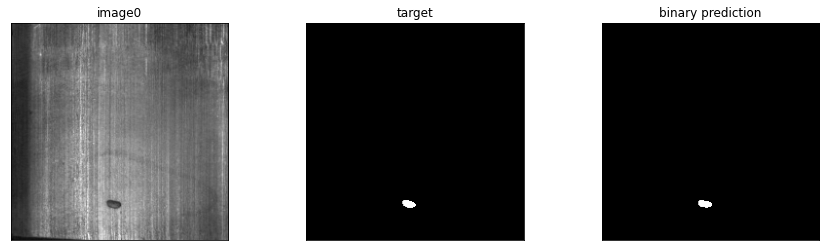

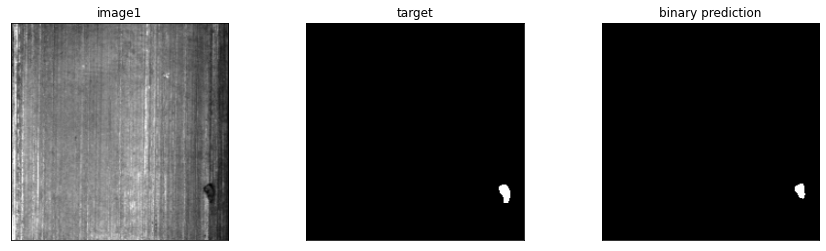

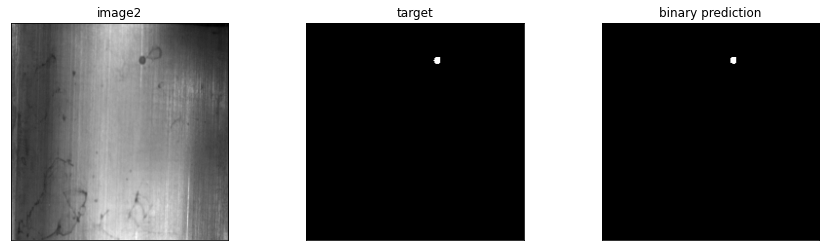

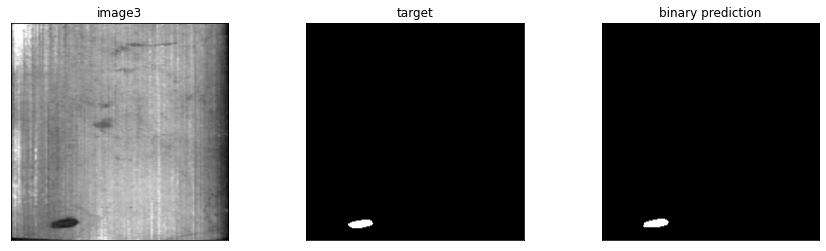

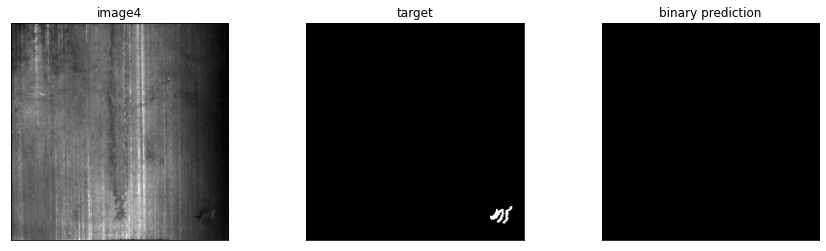

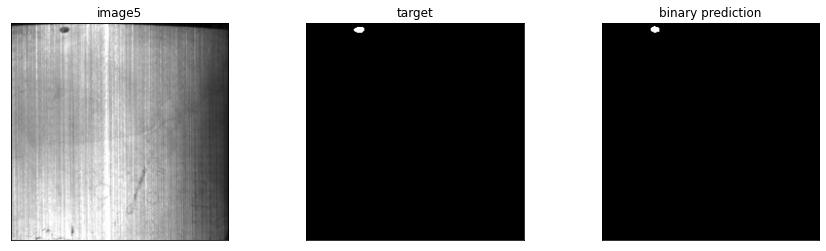

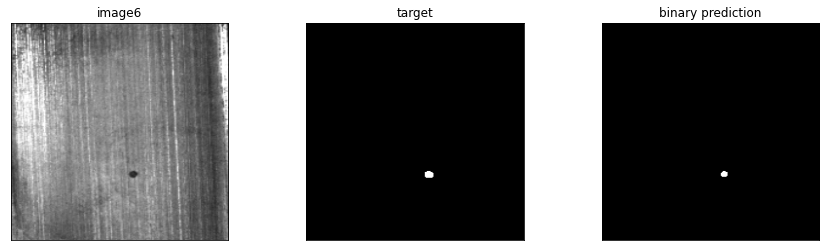

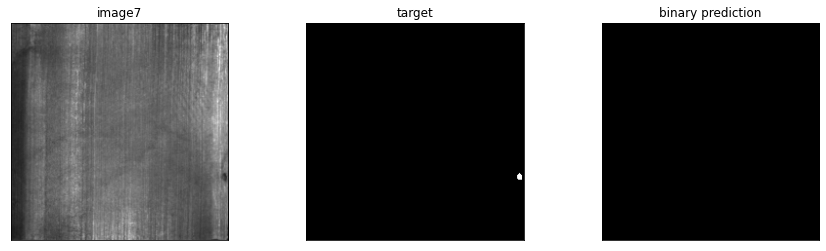

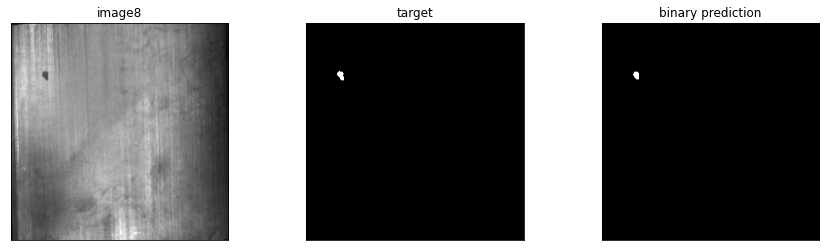

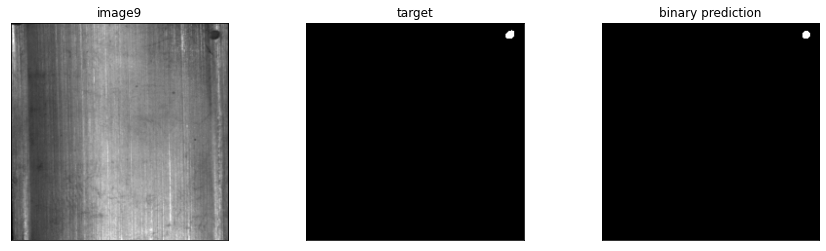

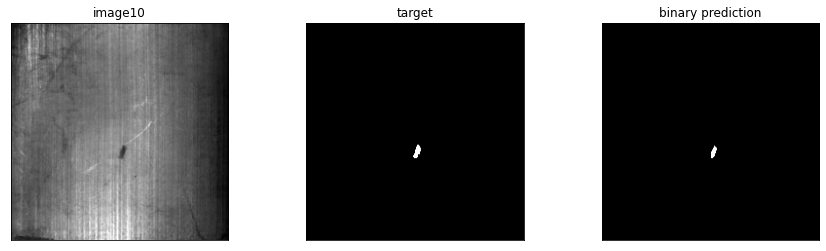

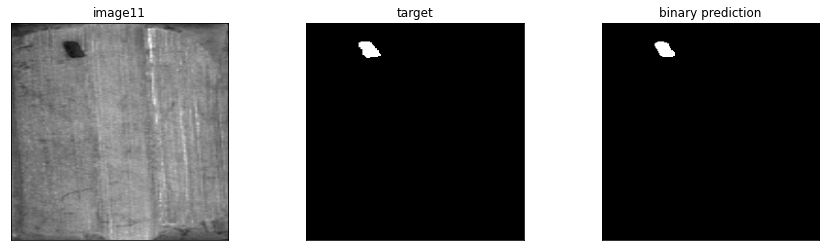

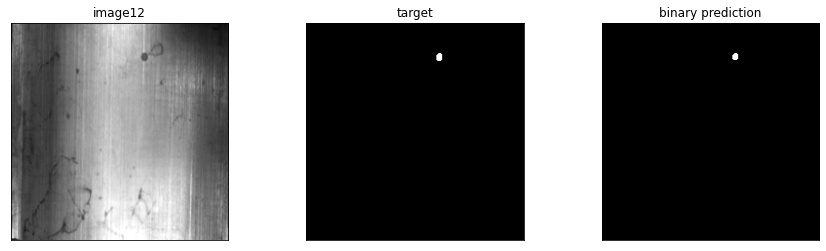

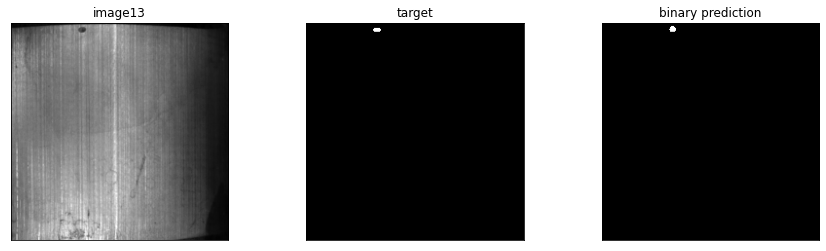

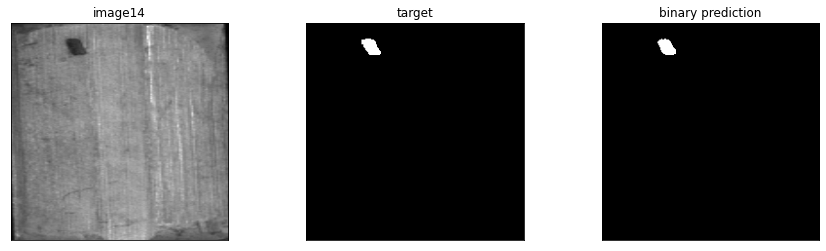

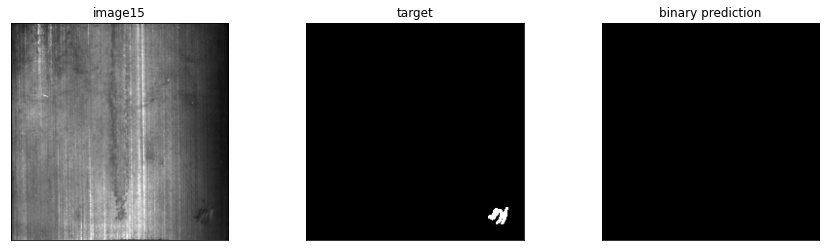

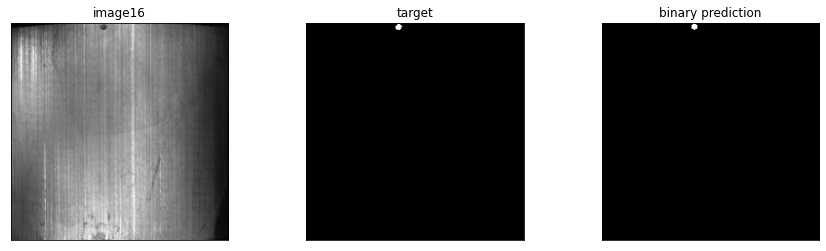

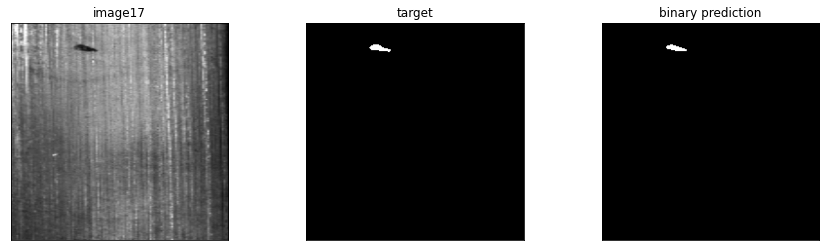

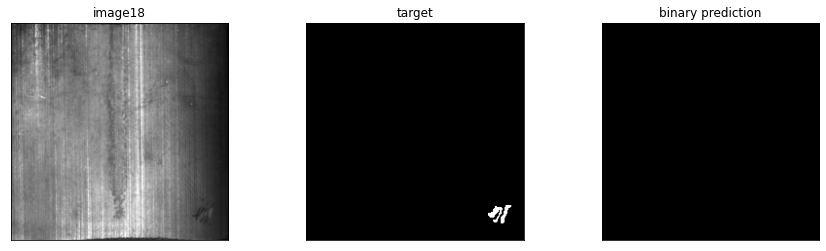

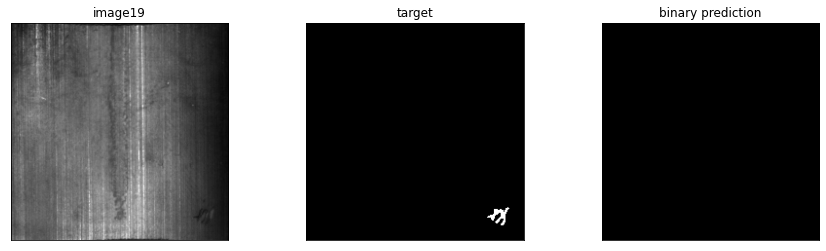

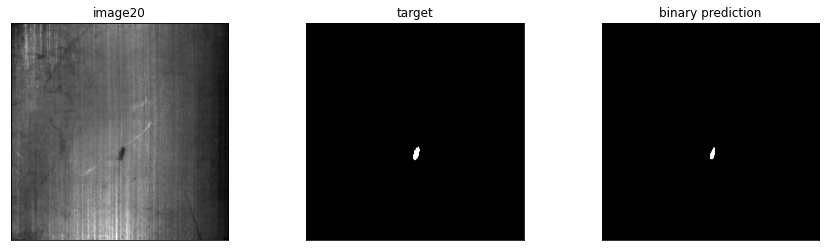

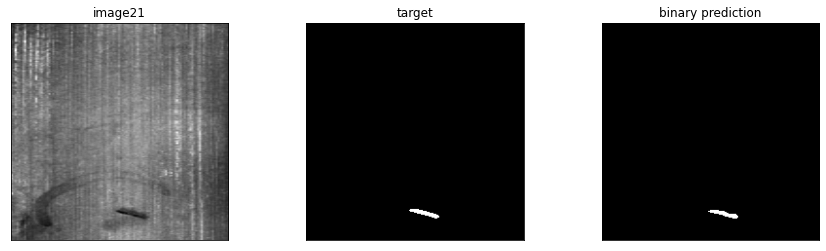

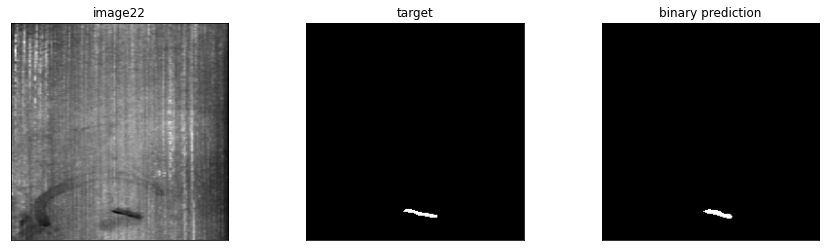

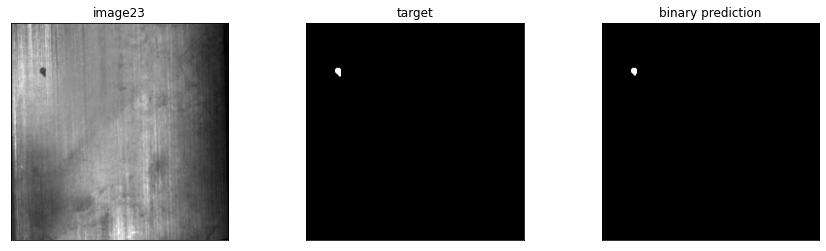

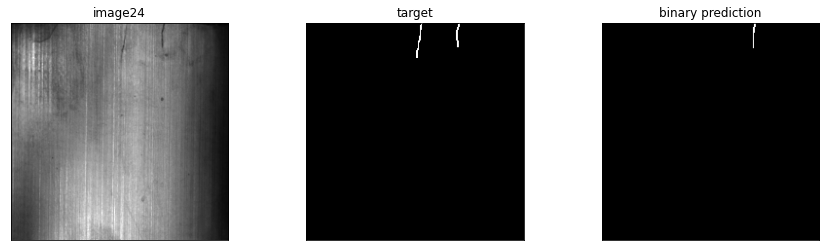

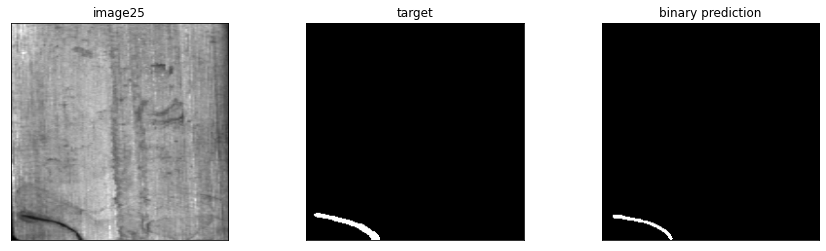

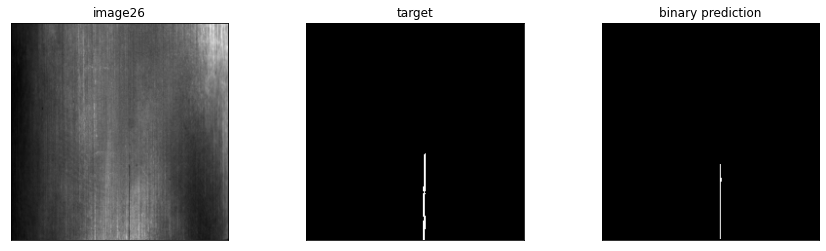

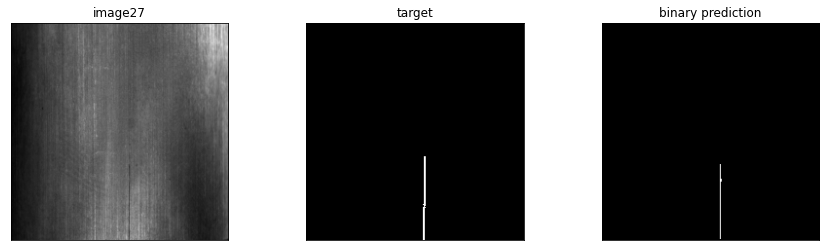

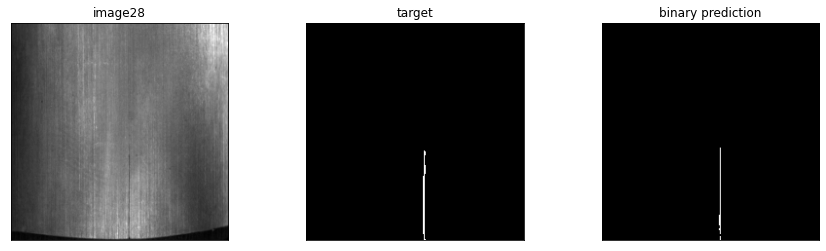

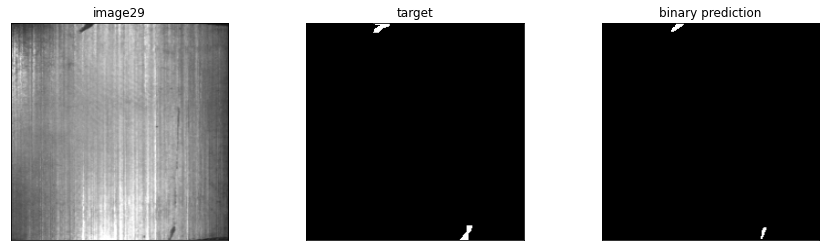

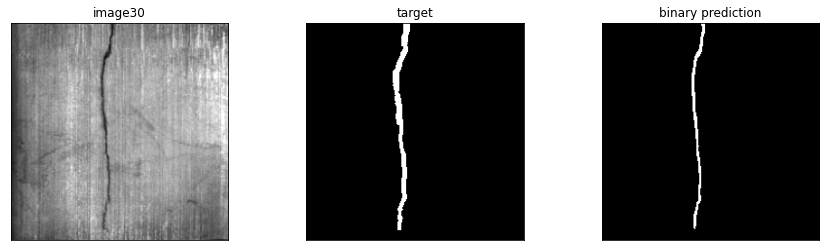

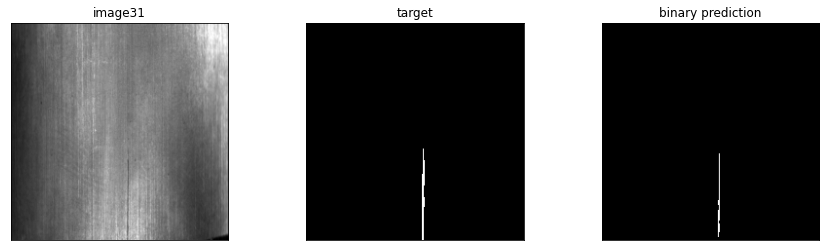

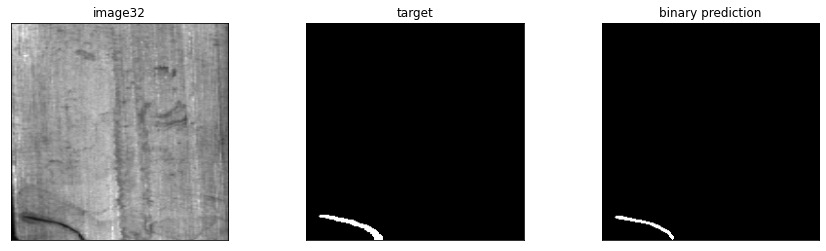

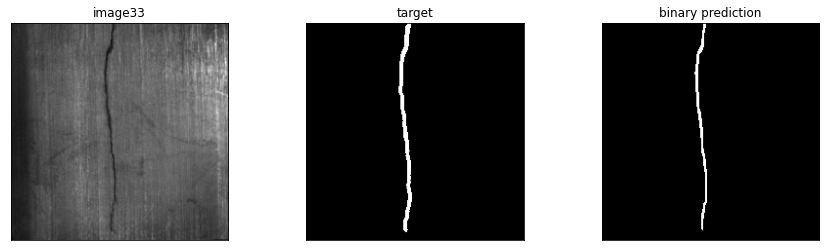

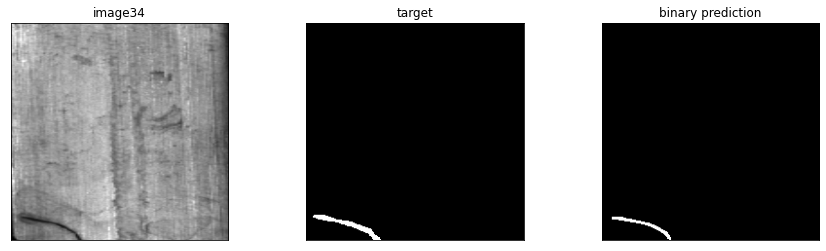

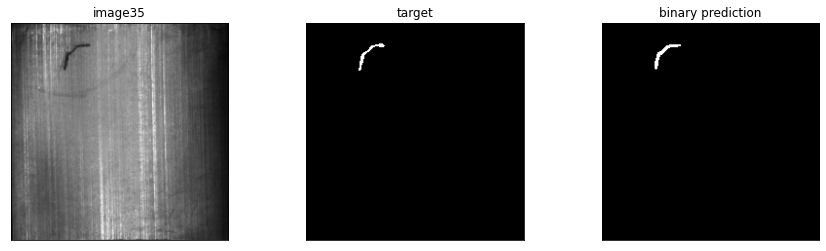

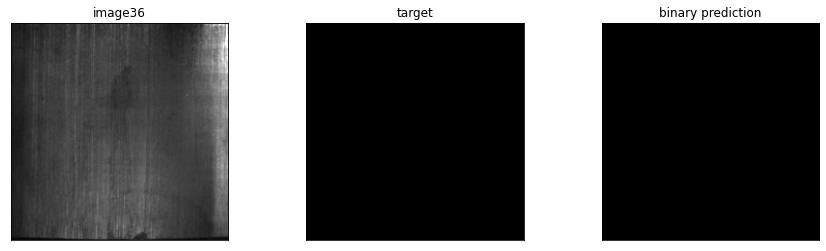

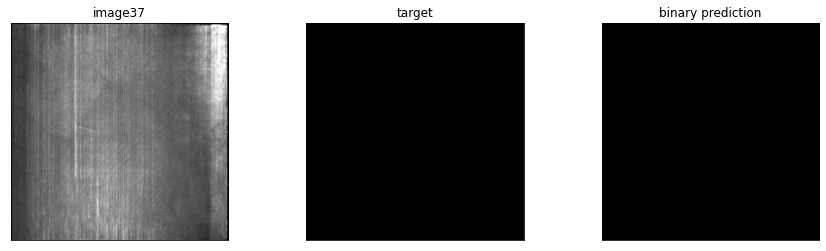

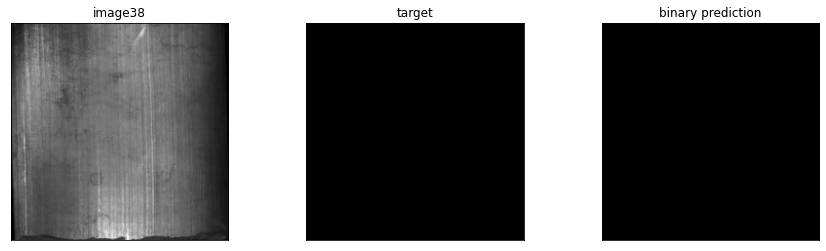

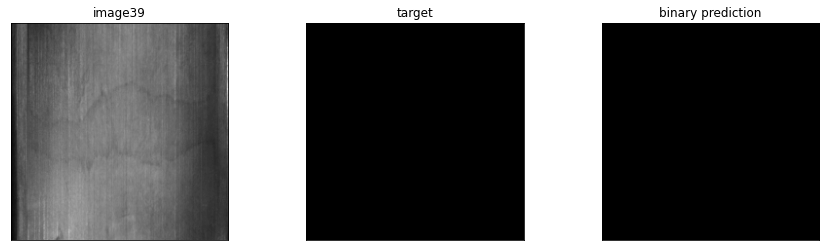

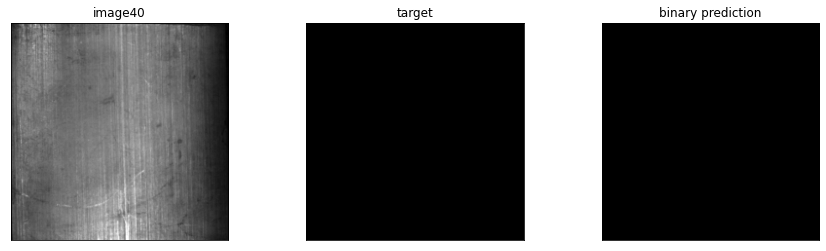

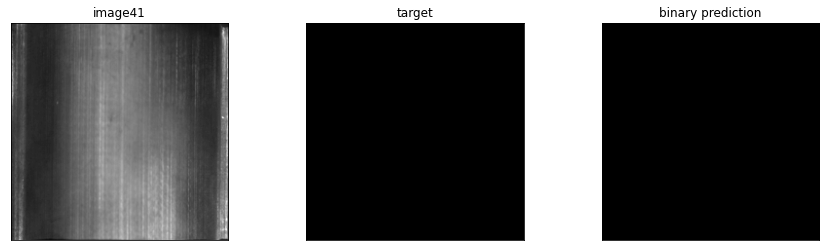

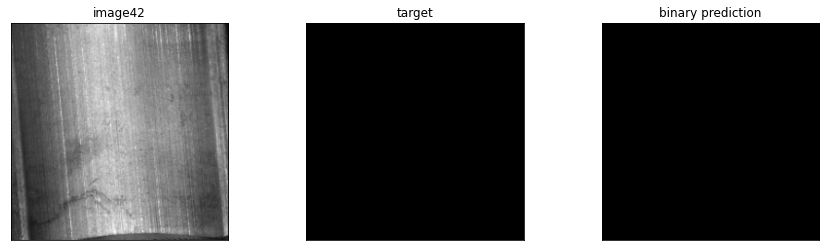

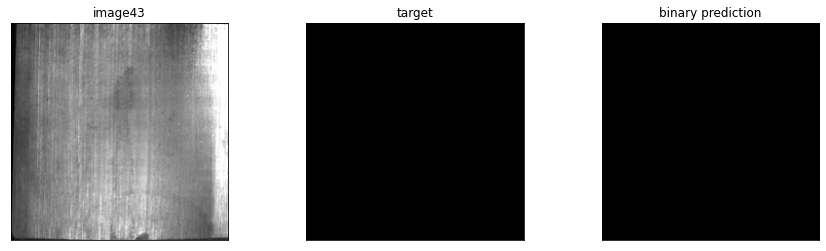

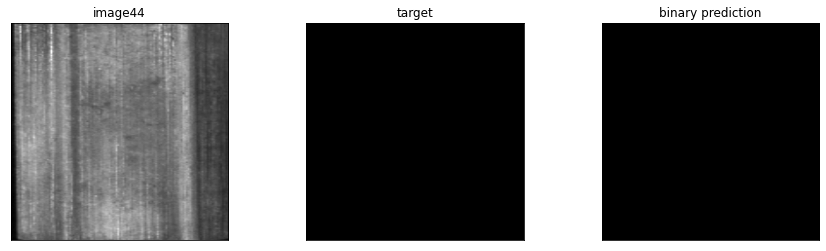

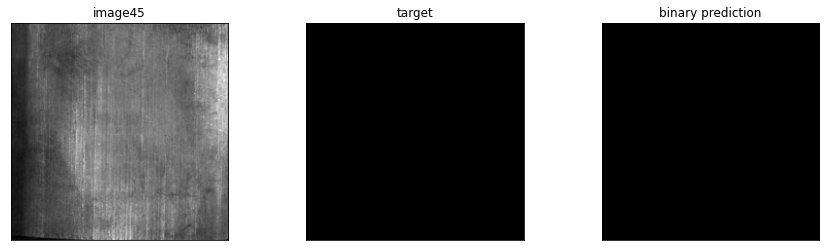

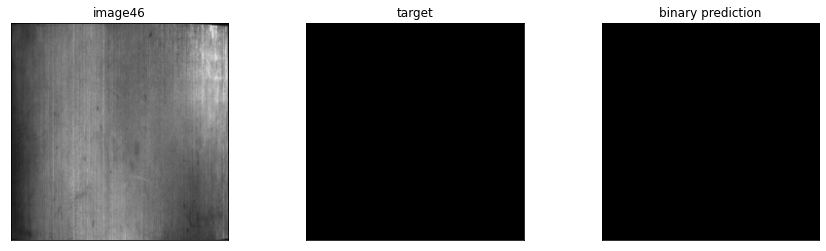

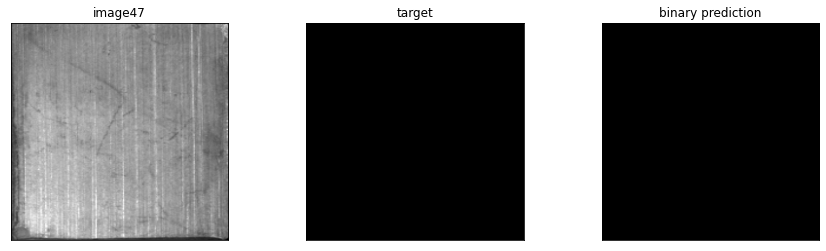

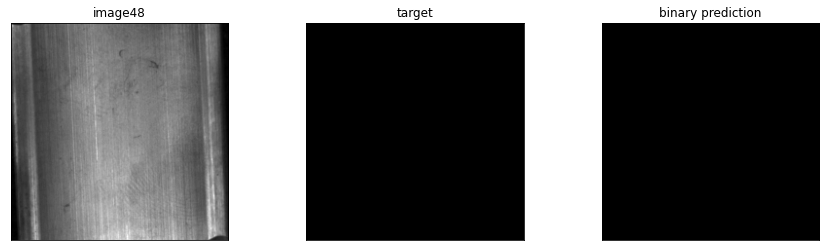

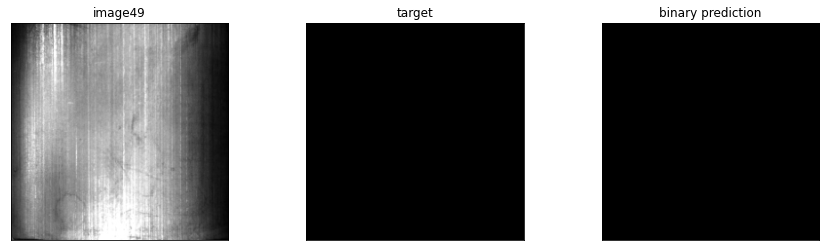

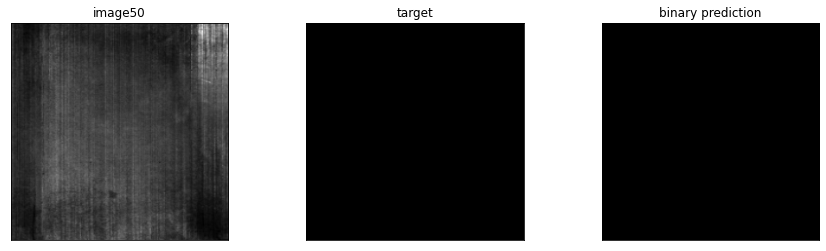

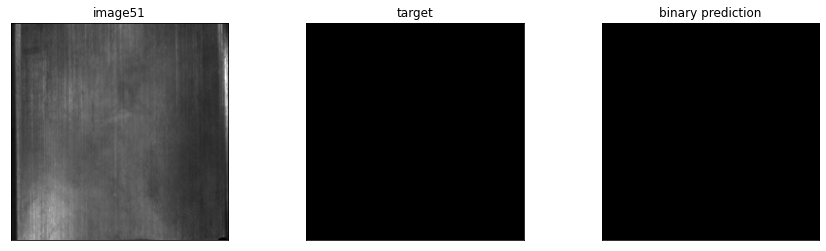

<Figure size 1080x288 with 0 Axes>

In [27]:
plot_prediction_results(model, train_on_gpu, loaders['test'], threshold)

###Get the inference performance metrics

In [28]:
df = get_inference_performance_metrics(model, train_on_gpu, loaders['test'], threshold)

In [29]:
df.describe()

specificity    sensitivity  ...            MAE        acc
count    53.000000   5.300000e+01  ...   5.300000e+01  53.000000
mean      0.085971   5.724813e-02  ...   7.577152e-05   0.085904
std       0.154059   1.446298e-01  ...   1.280399e-04   0.154026
min       0.018868  2.595243e-110  ...  3.152508e-113   0.018868
25%       0.025000   1.737424e-27  ...   2.110493e-30   0.025000
50%       0.037037   1.673047e-02  ...   2.934121e-05   0.036956
75%       0.071417   5.313093e-02  ...   6.975460e-05   0.071412
max       0.999900   9.518072e-01  ...   6.377560e-04   0.999821

[8 rows x 9 columns]

In [30]:
#!pip install pipreqs
#!pipreqs
